In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

from pandas_datareader import data, wb # This will import the data reader

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


---
### [Equilibrium Technology Diffusion, Trade, and Growth](https://christophertonetti.com/files/papers/PerlaTonettiWaugh_DiffusionTradeAndGrowth.pdf) by Perla, Tonetti, and Waugh (AER 2020)
---
### 7.1. Calibration

Table of Contents

- [Firm Moments from SLBD](#firm)


- [Firm moments from BEJK](#bejk)


- [Trade moments](#trade)


- [Productivity growth](#productivity)


- [Real interest rate](#real_rate)


- [Output of computations for calibration code](#output) and used in Section 7.2

---
### <a name="firm"></a> Firm/Establishment Dynamic Moments

The micro-level data that we use is from the Synthetic Longitudinal Business Database (SLBD) (U.S.Census Bureau (2011)). The SLBD is a public access database that synthesizes information on establishments’ employment, payroll, industry, and birth and death year. It is synthesized from the confidential, restricted-access Longitudinal Business Database that is maintained by the U.S. Census Bureau. 

We construct SLBD moments using only establishments with at least 20 employees, which is the cutoff value used in Hurst and Pugsley (2011). Following Hurst and Pugsley (2011), the motivation for this sample restriction is that many of these small establishments appear to have no intention to grow or innovate and, thus, their motives do not correspond with the motives of firms in our model.

#### How to access the SLBD

Instructions on how to access the SLBD and access our code is at [``/src/calibration/SLBD_instructions/SLBD_instructions.md``](https://github.com/jlperla/PerlaTonettiWaugh.jl/blob/master/src/calibration/SLBD_instructions/SLBD_instructions.md).

#### Entry
This moment is measured as the share of employment (out of total employment) that is employed in new establishments each year. Averaging across all time periods, this value is two percent.

- BGP entry (and exit rate): 0.02

On the balanced growth path, the entry rate exactly corresponds with the exit rate and, hence, this moment directly pins down the exit shock faced by firms.

#### Transition Moments

We construct these moments in the following way. For each year, we sort establishments into quartiles by employment size. We then compute the probabilities that establishments transition across size-quartiles at a five-year horizon, conditional on continuing to operate. We then average these transition probabilities across all years in the SLBD, i.e., from 1977–2000. The focus on the five-year horizons is to sweep out any transient fluctuations that may occur at higher frequencies due to shocks that are outside of our model. 

To give some perspective on the overall size of establishments, establishments larger than about 40 employees are in the top two quartiles; establishments larger than about 100 employees are in the
top quartile.

In [2]:
trans_moments = {"to_one": [0.26, 0.094], "to_two": [0.29, 0.136], "to_three": [0.285, 0.27], "to_four": [0.161, 0.501], 
                "quartile": [3, 4]}

trans_moments = pd.DataFrame(trans_moments)
trans_moments.set_index("quartile", inplace = True)

trans_moments.head()

,to_one,to_two,to_three,to_four
quartile,,,,
3,0.260,0.290,0.285,0.161
4,0.094,0.136,0.270,0.501


These transition probabilities are quite similar when restricting the sample to only manufacturing establishments, with
the only difference being a bit more persistence. Moreover, they look similar to the productivity transitions reported in Baily, Hulten, and Campbell (1992).

In [3]:
manuf_trans_moments = {"to_one": [0.18, 0.05], "to_two": [0.288, 0.15], "to_three": [0.32, 0.30], "to_four": [0.21, 0.49], 
                "quartile": [3, 4]}

manuf_trans_moments = pd.DataFrame(manuf_trans_moments)
manuf_trans_moments.set_index("quartile", inplace = True)

manuf_trans_moments.head()

,to_one,to_two,to_three,to_four
quartile,,,,
3,0.18,0.288,0.32,0.21
4,0.05,0.150,0.30,0.49


---

### <a name="firm"></a> Exporters from BEJK 

This moment is constructed from the finding of Bernard, Eaton, Jensen, and Kortum (2003), who use the 1992 U.S. Census of Manufactures to report that 20 percent of manufacturing establishments export. Because we associate each variety in our model with the output of an establishment within the entire U.S. aggregate economy, we adjust the Bernard et al. (2003) number.

In the SLBD data, when dropping establishments with < 20 employess, only 16.5 percent of establishments are in manufacturing and we assume, as a lower bound, that only manufactures are exported. This implies that the fraction of all establishments that export is 0.2*0.165 = 3.3 percent.

We also target the finding of Bernard et al. (2003) that exporters’ domestic shipments are 4.8 times larger than non-exporters’ shipments.

In [4]:
bejk = pd.DataFrame([0.033, 4.8])

---
### <a name="firm"></a> US Imports

We construct the aggregate import share as the value of imports of goods and services divided by GDP. Over the 1977–2000 time period, the average import share was 10.63 percent and quite stable.

In [5]:
codes = ["GDP", "IMPGS"] 

trade = data.DataReader(codes,"fred",1977)
        
trade = trade.resample("Y", convention= 'end').sum()

trade["imports_gdp"] =  100* (trade.IMPGS / trade.GDP )        

In [6]:
avg_trade = trade.loc[trade.index < '2001'].imports_gdp.mean()

print("Over the 1977–2000 time period, the average import share was:", round(avg_trade,3))

Over the 1977–2000 time period, the average import share was: 10.627


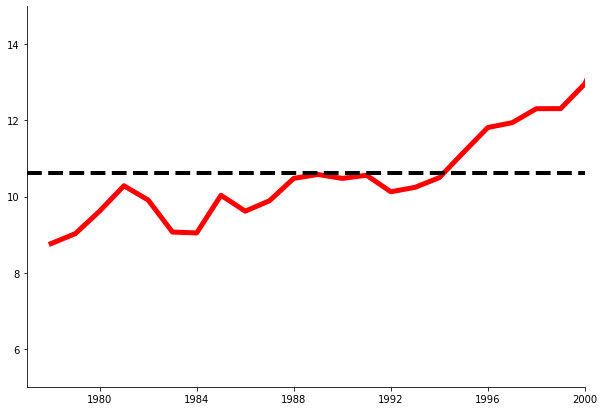

In [7]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(trade.index, trade["imports_gdp"], color = "red",
        linewidth = 5, label = "Imports")

ax.axhline(y= avg_trade,          # Set the value equall to the average
           color='k',       # make the color red
           linestyle='--',   # the line style
           linewidth=4)     # thickness of the line

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(dt.datetime(1977,1,1), dt.datetime(2000,1,1))
ax.set_ylim(5,15)

plt.show()

---
### <a name="productivity"></a> TFP Growth

To measure U.S. productivity growth, we use the [Bureau of Labor and Statistics Multifactor Productivity Database](https://www.bls.gov/mfp/home.htm). We focus on the private non-farm business sector and measure labor-augmenting productivity growth.

In [8]:
input_path = "src/calibration/data"

input_path = input_path + "/LATFP.xlsx"
## This is the historical multifactor dataset. 

bls = pd.read_excel(input_path, sheet_name = "XG",skiprows=6,nrows=72, headers = True, usecols = "A:G")
# Use the non-farm, private sector, sheet XG

# Note the orginal source of the data is
# https://www.bls.gov/mfp/special_requests/mfptablehis.xlsx
# As of 4/06, it appears that there was a revison of the historical tables.
# The TFP growth rate is 0.80 vs. 0.79 used in the paper. 

bls.dropna(inplace = True)

bls.set_index("Year", inplace = True)

bls.columns = ["RVA", "L", "K", "NVA", "NLC", "NKC"]

bls.drop(2018, axis = 0, inplace = True)

In [9]:
bls.tail()

,RVA,L,K,NVA,NLC,NKC
Year,,,,,,
2013.0,12138.731787,7024.670066,4376.594278,12312.7,7072.07,4481.46
2014.0,12520.291128,7201.584199,4500.352539,12922.7,7429.04,4697.01
2015.0,12964.111194,7375.836859,4637.590224,13476.3,7825.63,4835.53
2016.0,13173.415497,7505.505874,4777.426761,13839.6,8047.16,4962.26
2017.0,13528.844631,7649.337123,4916.218202,14451.1,8435.82,5162.35


In [10]:
bls["labor_share"] = bls["NLC"] / bls["NVA"]

reg_labor_share = 0.66

# Labor's share is nominal compensation vs. nomional value added.

bls["TFP"] = (bls["RVA"]/(bls["L"]**(bls["labor_share"])*bls["K"]**(1-bls["labor_share"]))).astype("float")

# TFP measure

bls["LA_TFP"] = (bls["TFP"]**(1/(bls["labor_share"]))).astype("float")

# Labor Augmenting.

In [11]:
start_year = 1976

mean_tfp = 100.*np.log(bls.loc[start_year:2000].LA_TFP).diff().mean()

#100.*np.log(bls.loc[start_year:2000].LA_TFP).diff()

In [12]:
print("Mean Labor Augmenting TFP growth")
print(round(mean_tfp,2))

Mean Labor Augmenting TFP growth
0.79


In [13]:
print("Standard Deviation Labor Augmenting TFP growth")

std_tfp = 100.*np.log(bls.loc[start_year:2000].LA_TFP).diff().std()
print(round(std_tfp,2))

Standard Deviation Labor Augmenting TFP growth
3.3


In [14]:
mean_50 = 100.*np.log(bls.loc[1949:1959].LA_TFP).diff().mean()

mean_60 = 100.*np.log(bls.loc[1959:1969].LA_TFP).diff().mean()

mean_70 = 100.*np.log(bls.loc[1969:1979].LA_TFP).diff().mean()

mean_80 = 100.*np.log(bls.loc[1979:1989].LA_TFP).diff().mean()

mean_90 = 100.*np.log(bls.loc[1989:1999].LA_TFP).diff().mean()

mean_00 = 100.*np.log(bls.loc[1999:2009].LA_TFP).diff().mean()

mean_10 = 100.*np.log(bls.loc[2009:2017].LA_TFP).diff().mean()

decadal_avg = [mean_50, mean_60, mean_70, mean_80, mean_90, mean_00, mean_10]

df_dec_avg = pd.DataFrame(decadal_avg, columns=['DateValue'])

std_dec_avg = df_dec_avg.std()[0]

print("standard deviation of these decadal averages")
print(round(std_dec_avg,2))

outdf = pd.DataFrame([std_dec_avg])
outdf.to_csv("./src/calibration/data/dec_std_avg.csv", index = False, header = False)

standard deviation of these decadal averages
0.78


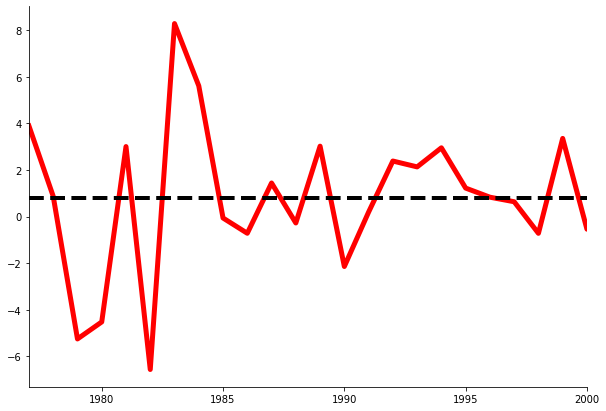

In [31]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(100.*np.log(bls.loc[start_year:2007].LA_TFP).diff(), color = "red",
        linewidth = 5, label = "Imports")

ax.axhline(y= mean_tfp,   
           # Set the value equall to the average
           color='k',       # make the color red
           linestyle='--',   # the line style
           linewidth=4)     # thickness of the line

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(1977,2000)
#ax.set_ylim(5,15)
plt.show()

---
### <a name="real_rate"></a> Real Interest Rates 

We construct the real interest rate as the difference between the rate of return on a one year U.S. treasury constant maturity nominal bond and the realized inflation rate. We use the U.S consumer price index, all items as our measure of realized inflation.

In [22]:
codes = ["GS1", "CPALTT01USM659N"] 

real_rates = data.DataReader(codes,"fred",1977)  # Read data from FRED and specify start date
real_rates = real_rates.resample("Y", convention= 'start').mean()

real_rates = real_rates.dropna()

real_rates["real_rate"] = real_rates["GS1"] - real_rates["CPALTT01USM659N"]

In [23]:
real_rates.head(5)

,GS1,CPALTT01USM659N,real_rate
DATE,,,
1977-12-31,6.088333,6.498055,-0.409722
1978-12-31,8.340000,7.615543,0.724457
1979-12-31,10.665000,11.224806,-0.559806
1980-12-31,12.048333,13.575444,-1.527111
1981-12-31,14.778333,10.352041,4.426293


In [24]:
avg_real = real_rates["real_rate"].loc[(real_rates.index < "2001") & (real_rates.index > "1977")].mean()
# This has the real rate starting in 1977 (so inflation is from 76 to 77), then ending in 2000
# so inflation is going from (99 to 00)

print("Average Real Rate", round(avg_real,3))

Average Real Rate 2.825


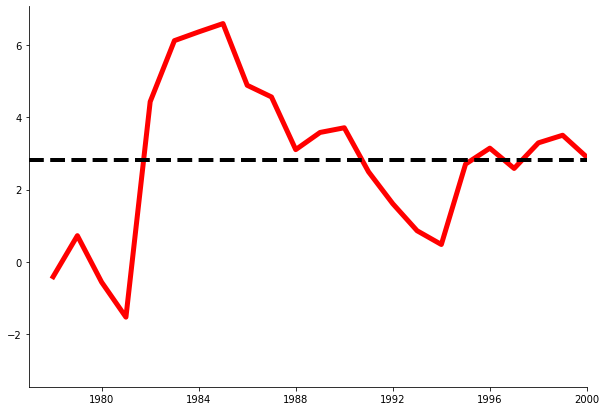

In [26]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(real_rates["real_rate"].dropna(), color = "red",
        linewidth = 5, label = "Imports")

ax.axhline(y=avg_real,   
           # Set the value equall to the average
           color='k',       # make the color red
           linestyle='--',   # the line style
           linewidth=4)     # thickness of the line

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(dt.datetime(1977,1,1), dt.datetime(2000,1,1))
#ax.set_ylim(5,15)
plt.show()

---
### <a name="output"></a> Save the Empirical Moments for Use as Input into Calibration

In [38]:
outpath = "src/calibration/data"

In [39]:
# These are the firm transition dyanics moments
trans_moments.to_csv(outpath + "/firm_moments.csv", index = False, header = False)

# Exit rate entry rate
entry_moment = pd.DataFrame([0.02])
entry_moment.to_csv(outpath + "/entry_moment.csv", index = False, header = False)

In [40]:
# The bejk moments
bejk.to_csv(outpath + "/bejk_moments.csv", index = False, header = False)

In [41]:
# Trade moments
trade_moment = pd.DataFrame([1-.01*avg_trade])
trade_moment.to_csv(outpath + "/trade_moments.csv", index = False, header = False)

In [42]:
# Growth and r moments

growth_and_r_moments = pd.DataFrame([.01*avg_real, .01*mean_tfp])
growth_and_r_moments.to_csv(outpath + "/growth_and_r_moments.csv", index = False, header = False)